In [1]:
import time
import datetime
import torch
import random
import numpy as np
import pandas as pd
import math
from sklearn.preprocessing import scale

In [2]:
# для воспроизводимости эксперимента:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
timesample = 0.004
start_time = 1.0
end_time = 2.0
n_receivers = 80
n_timesamples = int((end_time - start_time)/timesample)

data = np.empty([1,2,n_receivers,n_timesamples])

In [4]:
n_models = 1100

for i in range(n_models):
    if (i+1) % 100 == 0:
        print(i+1,'/',n_models)
    data_Z = pd.read_csv('csv_models_crack_density_kerogen_Z\\model_{}.csv'.format(i+1))
    model_gather_Z = np.array(data_Z[data_Z.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    data_X = pd.read_csv('csv_models_crack_density_kerogen_X\\model_{}.csv'.format(i+1))
    model_gather_X = np.array(data_X[data_X.columns[int(start_time/timesample):int(end_time/timesample)]])
    
    model_gather = np.vstack(([model_gather_Z],[model_gather_X]))
    model_gather = np.reshape(model_gather,(1,2,n_receivers,n_timesamples))
    
    data = np.vstack((data,model_gather))
    
data = data[1:]

100 / 1100
200 / 1100
300 / 1100
400 / 1100
500 / 1100
600 / 1100
700 / 1100
800 / 1100
900 / 1100
1000 / 1100
1100 / 1100


In [5]:
print(data.shape)
print(data[0])

(1100, 2, 80, 250)
[[[ 8.00936483e-04  1.02294818e-03  1.32944318e-03 ...  7.33114211e-06
    3.65297456e-06  5.33600814e-06]
  [ 8.13002698e-04  1.03995949e-03  1.35004241e-03 ...  1.79936615e-05
    1.57728209e-05  1.04900701e-05]
  [ 8.09254590e-04  1.03643746e-03  1.34863215e-03 ...  2.18033674e-05
    1.62670767e-05  1.47133496e-05]
  ...
  [ 1.56030874e-05  4.26389597e-05  6.87852298e-05 ...  4.44041565e-03
    3.75660928e-03 -1.94769260e-03]
  [-9.79333854e-05 -1.42892852e-04 -2.08559941e-04 ... -7.48212263e-03
   -3.12001863e-03  2.97511625e-03]
  [-3.46126268e-04 -5.30554680e-04 -6.34867465e-04 ...  4.77404147e-03
   -3.38328187e-03 -7.10949674e-03]]

 [[ 6.99258235e-05  8.44926399e-05  9.41825710e-05 ... -3.23014538e-05
   -4.81676834e-05 -5.05650532e-05]
  [ 5.52900601e-05  5.61434135e-05  7.12397741e-05 ...  1.55907910e-05
   -2.73467012e-05 -7.90447521e-05]
  [ 3.67106550e-05  4.03261947e-05  4.04063612e-05 ... -3.95337884e-06
   -1.77240872e-05  2.89054879e-05]
  ...
  [ 

In [6]:
# центрирование и нормализация данных
for i in range(n_models):
    for j in range(2):
        data[i,j] = scale(data[i,j], axis=1)

print(data[0])

[[[ 1.53660107e-02  1.97442103e-02  2.57884695e-02 ... -2.84347220e-04
   -3.56882819e-04 -3.23692420e-04]
  [ 1.61448283e-02  2.07643853e-02  2.70759203e-02 ... -3.70605829e-05
   -8.22643392e-05 -1.89791277e-04]
  [ 1.68876304e-02  2.17142086e-02  2.83468922e-02 ...  1.57958565e-04
    4.03381663e-05  7.32870035e-06]
  ...
  [ 6.01899933e-04  1.77915720e-03  2.91767739e-03 ...  1.93277123e-01
    1.63501276e-01 -8.48883732e-02]
  [-3.49869881e-03 -5.46663116e-03 -8.34096220e-03 ... -3.26713945e-01
   -1.35779169e-01  1.31012547e-01]
  [-1.40262303e-02 -2.21376169e-02 -2.67254204e-02 ...  2.11164993e-01
   -1.47604039e-01 -3.11487514e-01]]

 [[ 1.25326757e-02  1.61310792e-02  1.85247582e-02 ... -1.27202679e-02
   -1.66396622e-02 -1.72318783e-02]
  [ 7.36130482e-03  7.51916329e-03  1.03117793e-02 ...  1.74941396e-05
   -7.92534262e-03 -1.74887604e-02]
  [ 3.96892835e-03  4.52392376e-03  4.53622954e-03 ... -2.27311389e-03
   -4.38695591e-03  2.77081350e-03]
  ...
  [ 1.98760282e-02  1.2

In [7]:
frac_params = pd.read_csv('frac_params_crack_density_kerogen.csv')
#frac_params['aspect_ratio1'] *= 1000
#print(frac_params['aspect_ratio1'])
#frac_params = np.array(frac_params[['aspect_ratio1']] * 1000) # умножаем, чтобы числа слишком маленькими не были
frac_params = np.array(frac_params[['e1_t']])

In [8]:
X_train = torch.Tensor(data[:800])
X_validation = torch.Tensor(data[800:1100])

Y_train = torch.Tensor(frac_params[:800])
Y_validation = torch.Tensor(frac_params[800:1100])

In [13]:
"""
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        #self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=3, padding=0, stride=2)
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = torch.nn.Linear(10*15*n3,50)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=50)
        self.fc2 = torch.nn.Linear(50,20)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=20)
        
        self.out = torch.nn.Linear(20,1) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
            
        x = self.out(x)
        
        return x
        
"""

In [22]:
#"""
# изменил кол-во нейронов в полносвязных слоях
class FracAnisotropyNet(torch.nn.Module):
    def __init__(self,n1,n2,n3,n4,prob=0.0):
        super(FracAnisotropyNet,self).__init__()
        
        self.conv1 = torch.nn.Conv2d(in_channels=2, out_channels=n1, kernel_size=(2,4), padding=0, stride=2)
        self.ac1 = torch.nn.ReLU()
        self.bn1 = torch.nn.BatchNorm2d(num_features=n1)
        self.do1 = torch.nn.Dropout(p=prob)
        #self.pool1 = torch.nn.MaxPool1d(kernel_size=2, stride=2)
        
        self.conv2 = torch.nn.Conv2d(in_channels=n1, out_channels=n2, kernel_size=2, padding=0, stride=(1,2))
        self.ac2 = torch.nn.ReLU()
        self.bn2 = torch.nn.BatchNorm2d(num_features=n2)
        self.do2 = torch.nn.Dropout(p=prob)
        
        self.conv3 = torch.nn.Conv2d(in_channels=n2, out_channels=n3, kernel_size=(2,3), padding=1, stride=(1,2))
        self.ac3 = torch.nn.ReLU()
        self.bn3 = torch.nn.BatchNorm2d(num_features=n3)
        self.do3 = torch.nn.Dropout(p=prob)
        
        self.conv4 = torch.nn.Conv2d(in_channels=n3, out_channels=n4, kernel_size=2, padding=0, stride=2)
        self.ac4 = torch.nn.ReLU()
        self.bn4 = torch.nn.BatchNorm2d(num_features=n4)
        self.do4 = torch.nn.Dropout(p=prob)
        self.pool4 = torch.nn.MaxPool2d(kernel_size=(2,1), stride=(2,1))
        
        self.fc1 = torch.nn.Linear(10*15*n4,200)
        self.ac1_ = torch.nn.Tanh()
        #self.bn1_ = torch.nn.BatchNorm1d(num_features=100)
        self.fc2 = torch.nn.Linear(200,80)
        self.ac2_ = torch.nn.Tanh()
        #self.bn2_ = torch.nn.BatchNorm1d(num_features=40)
        self.fc3 = torch.nn.Linear(80,20)
        self.ac3_ = torch.nn.Tanh()
        
        self.out = torch.nn.Linear(20,1) 
        
    def forward(self,x):
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv1(x)
        x = self.ac1(x)
        x = self.bn1(x)
        x = self.do1(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv2(x)
        x = self.ac2(x)
        x = self.bn2(x)
        x = self.do2(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
            
        x = self.conv3(x)
        x = self.ac3(x)
        x = self.bn3(x)
        x = self.do3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        #x = self.pool3(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = self.conv4(x)
        x = self.ac4(x)
        x = self.bn4(x)
        x = self.do4(x)
        x = self.pool4(x)
        #print(x.size(0),' x ', x.size(1),' x ', x.size(2),' x ', x.size(3))
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        
        x = self.fc1(x)
        x = self.ac1_(x)
        #x = self.bn1_(x)
        x = self.fc2(x)
        x = self.ac2_(x)
        #x = self.bn2_(x)
        x = self.fc3(x)
        x = self.ac3_(x)
            
        x = self.out(x)
        
        return x
        
#"""

In [23]:
device = torch.device('cpu')

#neural_net = FracAnisotropyNet(4,6,2)
neural_net = FracAnisotropyNet(4,6,4,2)
neural_net = neural_net.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=3.0e-4)

In [24]:
batch_size = 100
N = len(X_train)

test_loss_history = []
train_loss_history = []

X_validation = X_validation.to(device)
Y_validation = Y_validation.to(device)

start_time = datetime.datetime.now()
epochs = 200

for epoch in range(epochs):
    order = np.random.permutation(N)
  
    loss_sum = 0.0
    for batch_init in range(0,N,batch_size):
        optimizer.zero_grad()
        neural_net.train()
    
        X_batch = X_train[order[batch_init:batch_init+batch_size]].to(device)
        y_batch = Y_train[order[batch_init:batch_init+batch_size]].to(device)
    
        pred = neural_net.forward(X_batch)
        #loss_value = weighted_loss(pred,y_batch)
        loss_value = loss(pred,y_batch)
        loss_sum += loss_value
        loss_value.backward()
    
        optimizer.step()
    
    neural_net.eval()
    pred = neural_net.forward(X_validation)
  
    tr_l = loss_sum/(N/batch_size)
    te_l = loss(pred,Y_validation)
    train_loss_history.append(tr_l.data.cpu())
    test_loss_history.append(te_l.data.cpu())
  
    print('epoch #', epoch+1,':\n\tTrain Loss:\t',tr_l.data.cpu().numpy(),'\n\tTest Loss:\t',te_l.data.cpu().numpy())

educ_time = datetime.datetime.now() - start_time
print('Time elapsed:', educ_time)

epoch # 1 :
	Train Loss:	 0.00628378 
	Test Loss:	 0.0029443235
epoch # 2 :
	Train Loss:	 0.0025592244 
	Test Loss:	 0.0022246735
epoch # 3 :
	Train Loss:	 0.0012890785 
	Test Loss:	 0.0022776895
epoch # 4 :
	Train Loss:	 0.0011846053 
	Test Loss:	 0.0025750792
epoch # 5 :
	Train Loss:	 0.0009321249 
	Test Loss:	 0.0020212873
epoch # 6 :
	Train Loss:	 0.0009085428 
	Test Loss:	 0.0010728225
epoch # 7 :
	Train Loss:	 0.00089069456 
	Test Loss:	 0.0008146334
epoch # 8 :
	Train Loss:	 0.0008966467 
	Test Loss:	 0.00080542004
epoch # 9 :
	Train Loss:	 0.0008599896 
	Test Loss:	 0.00082216546
epoch # 10 :
	Train Loss:	 0.00088402495 
	Test Loss:	 0.00083185046
epoch # 11 :
	Train Loss:	 0.00085648254 
	Test Loss:	 0.00080322457
epoch # 12 :
	Train Loss:	 0.0008720942 
	Test Loss:	 0.00080772233
epoch # 13 :
	Train Loss:	 0.0008540672 
	Test Loss:	 0.00080944505
epoch # 14 :
	Train Loss:	 0.0008581035 
	Test Loss:	 0.00082362874
epoch # 15 :
	Train Loss:	 0.00085845264 
	Test Loss:	 0.000805

epoch # 122 :
	Train Loss:	 0.00085561146 
	Test Loss:	 0.0007777166
epoch # 123 :
	Train Loss:	 0.0008543603 
	Test Loss:	 0.00098294
epoch # 124 :
	Train Loss:	 0.0008838771 
	Test Loss:	 0.0010480625
epoch # 125 :
	Train Loss:	 0.0009264926 
	Test Loss:	 0.00081176107
epoch # 126 :
	Train Loss:	 0.000843241 
	Test Loss:	 0.0007745164
epoch # 127 :
	Train Loss:	 0.0008076303 
	Test Loss:	 0.00078565243
epoch # 128 :
	Train Loss:	 0.0008213508 
	Test Loss:	 0.00077234366
epoch # 129 :
	Train Loss:	 0.0008562043 
	Test Loss:	 0.0008653722
epoch # 130 :
	Train Loss:	 0.0008223846 
	Test Loss:	 0.00076928106
epoch # 131 :
	Train Loss:	 0.00081574457 
	Test Loss:	 0.0007833403
epoch # 132 :
	Train Loss:	 0.00081646926 
	Test Loss:	 0.0007873143
epoch # 133 :
	Train Loss:	 0.0008427761 
	Test Loss:	 0.00077562797
epoch # 134 :
	Train Loss:	 0.0008259213 
	Test Loss:	 0.0007634069
epoch # 135 :
	Train Loss:	 0.0008782635 
	Test Loss:	 0.0008247712
epoch # 136 :
	Train Loss:	 0.00088571187 


In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
num = 30
def moving_average(a, n=num): # среднее скользящее среднее
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

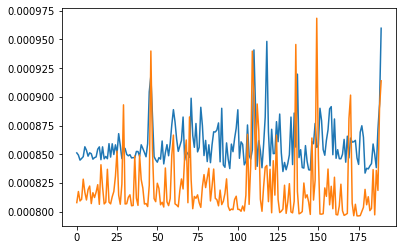

In [17]:
plt.plot(train_loss_history[10:])
plt.plot(test_loss_history[10:])

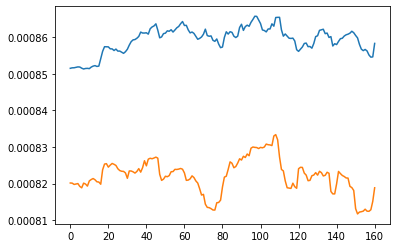

In [18]:
avg_loss_train = moving_average(train_loss_history)
avg_loss_test = moving_average(test_loss_history)
plt.plot(avg_loss_train[10:])
plt.plot(avg_loss_test[10:])

In [19]:
print('Train Loss: ', avg_loss_train[-1])
print('Test Loss:  ', avg_loss_test[-1])

Train Loss:  0.0008582666593914231
Test Loss:   0.000818871120767047


In [20]:
pred = neural_net.forward(X_validation)
pred = pred.data.cpu().numpy()
y_val = Y_validation.data.cpu().numpy()
print('Predicted\tReal value\tDifference')
sum_dn = 0.0
sum_e1_n = 0.0
sum_e1_t = 0.0
sum_asp = 0.0
sum_asp_real = 0.0
sum_e1_n_real = 0.0
sum_e1_t_real = 0.0
sum_dn_real = 0.0
sum_dn_sq = 0.0
for i in range(300):
    dif = abs(pred[i]-y_val[i])
    print(pred[i],'\t',y_val[i],'\t',dif)
    sum_e1_n += dif[0]
    #sum_e1_t += dif[1]
    #sum_asp += dif[0]
    #sum_asp_real += y_val[i][0]
    sum_e1_n_real += y_val[i][0]
    #sum_e1_t_real += y_val[i][1]
    #sum_dn += dif[0]
    #sum_dn_sq += dif[0]**2
    #sum_dn_real == y_val[i][0]
    
#mean_e1_n_real = sum_e1_n_real/300
#mean_e1_t_real = sum_e1_t_real/300

Predicted	Real value	Difference
[0.04052216] 	 [0.04865594] 	 [0.00813378]
[0.04041448] 	 [0.00131272] 	 [0.03910177]
[0.04025684] 	 [0.02885071] 	 [0.01140613]
[0.04080586] 	 [0.06555364] 	 [0.02474777]
[0.04082093] 	 [0.07504845] 	 [0.03422753]
[0.04056231] 	 [0.04457628] 	 [0.00401397]
[0.04044437] 	 [0.05668631] 	 [0.01624194]
[0.04050762] 	 [0.03948972] 	 [0.0010179]
[0.04066939] 	 [0.06672426] 	 [0.02605487]
[0.04048006] 	 [0.00774191] 	 [0.03273815]
[0.04058696] 	 [0.04464912] 	 [0.00406216]
[0.04041816] 	 [0.02605487] 	 [0.01436328]
[0.04048127] 	 [0.05434454] 	 [0.01386327]
[0.04044273] 	 [0.00645472] 	 [0.033988]
[0.04033082] 	 [0.00390701] 	 [0.03642381]
[0.04050809] 	 [0.08524491] 	 [0.04473682]
[0.04066326] 	 [0.073179] 	 [0.03251574]
[0.04034934] 	 [0.01589694] 	 [0.02445241]
[0.0405194] 	 [0.0582663] 	 [0.0177469]
[0.04048488] 	 [0.04703223] 	 [0.00654736]
[0.04051064] 	 [0.02770818] 	 [0.01280246]
[0.04078419] 	 [0.05826256] 	 [0.01747837]
[0.04085141] 	 [0.09051346] 	 

[0.04058263] 	 [0.09889586] 	 [0.05831323]
[0.04048171] 	 [0.05909827] 	 [0.01861656]
[0.04053473] 	 [0.07896243] 	 [0.0384277]
[0.04044645] 	 [0.00619804] 	 [0.0342484]
[0.04047579] 	 [0.04738759] 	 [0.0069118]
[0.04041169] 	 [0.05943722] 	 [0.01902553]
[0.04047126] 	 [0.07395958] 	 [0.03348833]
[0.04066198] 	 [0.06372502] 	 [0.02306303]
[0.04052746] 	 [0.08207971] 	 [0.04155225]
[0.04049809] 	 [0.05364284] 	 [0.01314474]
[0.04051353] 	 [0.07498813] 	 [0.0344746]
[0.04052401] 	 [0.02986383] 	 [0.01066018]
[0.04032992] 	 [0.01206112] 	 [0.0282688]
[0.04048011] 	 [0.07622185] 	 [0.03574174]
[0.04088429] 	 [0.06793042] 	 [0.02704613]
[0.04064046] 	 [0.07184577] 	 [0.03120531]
[0.04041006] 	 [0.02019348] 	 [0.02021658]
[0.04041922] 	 [0.04366801] 	 [0.00324879]
[0.04079988] 	 [0.07792675] 	 [0.03712687]
[0.04041494] 	 [0.05848807] 	 [0.01807313]
[0.04037245] 	 [0.03785859] 	 [0.00251386]
[0.0404648] 	 [0.011108] 	 [0.0293568]
[0.04084747] 	 [0.09978873] 	 [0.05894125]
[0.04039613] 	 [0.04

In [21]:
print('Mean e1_n difference: ', sum_e1_n/300)
#print('Mean e1_t difference: ', sum_e1_t/300)
#print('Mean aspect ratio difference: ', sum_asp/300)

#print(mean_asp_real)
print('\nRelative e1_n accuracy: ', sum_e1_n/sum_e1_n_real)
#print('Relative e1_t accuracy: ', sum_e1_t/300/mean_e1_t_real)
#print('Relative aspect ratio accuracy: ', sum_asp/sum_asp_real)
#print('Mean dn difference: ', sum_dn/300)
#print('dn MSE: ', math.sqrt(sum_dn_sq/300))
#print('\nRelative dn accuracy: ', sum_dn/sum_dn_real)

Mean e1_n difference:  0.025553080700337887

Relative e1_n accuracy:  0.49722507935293675


In [ ]:
print(Y_validation)

In [ ]:
print(abs((pred-Y_validation).data.cpu().numpy()))